<a href="https://colab.research.google.com/github/Mostofa-Najmus-Sakib/Data-Science-CS533/blob/main/Assisgnment5/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5
## CS533, Fall 2019

## Setup

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
import sklearn.linear_model as lm
import sklearn.naive_bayes as nb
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

## Part 1: Load and Prepare Data

The follwoing code loops over all text files and reads them into records, that we then turn into a Pandas data frame.

In [ ]:
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text())
     for f in Path('bbc-fulltext/bbc').glob('*/*.txt')),
    columns=['category', 'file', 'text']
)
articles.head()

,category,file,text
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,004.txt,High fuel prices hit BA's profits\n\nBritish A...
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...


#### 1. Show the distribution of categories - how many articles are there in each category?

let's draw a count plot to see the distribution of categories in our data

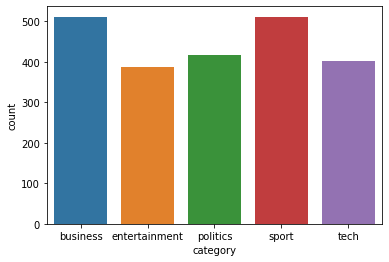

In [ ]:
sns.countplot(articles['category'])

Let's see the count of each category numerically

In [ ]:
articles['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

##### Looks like we have 511 articles on sports, 510 on business, 417 on politics, 401 on tech, and 386 on entertainment

#### 2. Select 20% of the data for testing the classifiers.

In [ ]:
articlesTest = articles.sample(frac=0.20)
articlesTest.head()

,category,file,text
628,entertainment,119.txt,Ring of Fire hit co-writer dies\n\nMerle Kilgo...
423,business,424.txt,EU-US seeking deal on air dispute\n\nThe EU an...
1712,sport,400.txt,England given tough Sevens draw\n\nEngland wil...
1093,politics,198.txt,Police chief backs drinking move\n\nA chief co...
756,entertainment,247.txt,Spears seeks aborted tour payment\n\nSinger Br...


In [ ]:
articlesTest['category'].value_counts()

sport            100
business          95
entertainment     89
politics          88
tech              73
Name: category, dtype: int64

In [ ]:
train_mask = pd.Series(True, index=articles.index)
train_mask[articlesTest.index] = False
articlesTrain = articles[train_mask].copy()
articlesTrain.head()

,category,file,text
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,004.txt,High fuel prices hit BA's profits\n\nBritish A...
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...


In [ ]:
(len(articles) == len(articlesTrain) + len(articlesTest))

True

#### 3. Set up a CountVectorizer and a TfidfVectorizer, each with “stop_words='english'” and transform the training and test data into document-term matrices.

Setting up a CountVectorizer and a TfidfVectorizer

In [ ]:
txtcountCV = CountVectorizer(stop_words='english')
txtcountTFIDFV = TfidfVectorizer(stop_words='english')

In [ ]:
articlesTrain_CV_tm = txtcountCV.fit_transform(articlesTrain['text'])
articlesTest_CV_tm = txtcountCV.transform(articlesTest['text'])

In [ ]:
articlesTrain_CV_tm

<1780x26610 sparse matrix of type '<class 'numpy.int64'>'
	with 257428 stored elements in Compressed Sparse Row format>

In [ ]:
articlesTest_CV_tm

<445x26610 sparse matrix of type '<class 'numpy.int64'>'
	with 61962 stored elements in Compressed Sparse Row format>

In [ ]:
articlesTrain_TFIDFV_tm = txtcountTFIDFV.fit_transform(articlesTrain['text'])
articlesTest_TFIDFV_tm = txtcountTFIDFV.transform(articlesTest['text'])

In [ ]:
articlesTrain_TFIDFV_tm

<1780x26610 sparse matrix of type '<class 'numpy.float64'>'
	with 257428 stored elements in Compressed Sparse Row format>

In [ ]:
articlesTest_TFIDFV_tm

<445x26610 sparse matrix of type '<class 'numpy.float64'>'
	with 61962 stored elements in Compressed Sparse Row format>

## Part 2: Classification

#### Train a Naive Bayes classifier on the training data (using count vectors), and test its accuracy on both the training data and the test data.

In [ ]:
bayes = nb.MultinomialNB()
bayes.fit(articlesTrain_CV_tm, articlesTrain['category'])
bayes.feature_log_prob_

array([[-11.55212695,  -6.18615093, -10.85897977, ..., -11.55212695,
        -11.55212695, -11.55212695],
       [-10.59148399,  -6.67946099, -11.28463117, ..., -10.59148399,
        -11.28463117, -10.18601888],
       [-10.85038508,  -6.48728646, -11.54353226, ..., -11.54353226,
        -11.54353226, -11.54353226],
       [-10.3869317 ,  -8.15333948, -11.48554399, ..., -11.48554399,
        -10.79239681, -11.48554399],
       [-10.95352215,  -6.57149552, -11.64666934, ..., -11.64666934,
        -11.64666934, -11.64666934]])

In [ ]:
bayes.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype='<U13')

training accuracy of this classifier:

In [ ]:
trainAccuracyBayes = (articlesTrain['category'] == bayes.predict(articlesTrain_CV_tm)).mean()
trainAccuracyBayes

0.9943820224719101

test accuracy of this classifier:

In [ ]:
testAccuracyBayes = (articlesTest['category'] == bayes.predict(articlesTest_CV_tm)).mean()
testAccuracyBayes

0.9730337078651685

#### Another way to classify is with “k nearest neighbors”: to classify a document, find the closest data points and use the class most of them have. The KNeighborsClassifier in scikit-learn does this. Train one of these classifiers (with TF-IDF vectors), using 5 neighbors

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)

In [ ]:
neigh.fit(articlesTrain_TFIDFV_tm, articlesTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### measure its accuracy on both training and test data.

training accuracy of this classifier

In [ ]:
trainAccuracyKNN = (articlesTrain['category'] == neigh.predict(articlesTrain_TFIDFV_tm)).mean()
trainAccuracyKNN

0.9651685393258427

test accuracy of this classifier

In [ ]:
testAccuracyKNN = (articlesTest['category'] == neigh.predict(articlesTest_TFIDFV_tm)).mean()
testAccuracyKNN

0.9258426966292135

## Part 3: Clustering

So far our machine learning has been supervised: we have the labels. We can also do unsupervised learning, where we learn patterns from the data without labels. One such technique is clustering: putting objects (such as documents) into groups, using only the features in the documents and not using external group labels.
K-means is a simple way of clustering a group of data points into k clusters. KMeans in scikit-learn implements this; after training, its predict method outputs cluster numbers for data points - this is how we will get the clusters. It’s like the classifier output, except cluster numbers. The most important parameter to KMeans is the number of clusters to find - it cannot do that on its own.

#### 1. Fit a K-means model with 5 clusters to your data (using the TF-IDF matrix), and get the cluster numbers for your training data.

In [ ]:
kmeans5Clusters = KMeans(n_clusters=5, random_state=0).fit(articlesTrain_TFIDFV_tm)

In [ ]:
predictedOutput5Clusters = kmeans5Clusters.predict(articlesTrain_TFIDFV_tm)

In [ ]:
type(predictedOutput5Clusters)

numpy.ndarray

In [ ]:
articlesTrain5Clusters = articlesTrain
articlesTrain5Clusters['predictedCluster'] = predictedOutput5Clusters

In [ ]:
articlesTrain5Clusters.head()

,category,file,text,predictedCluster
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,1
1,business,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,1
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,1
3,business,004.txt,High fuel prices hit BA's profits\n\nBritish A...,1
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,1


#### 2. For each cluster, show the distribution of document categories (from the original labels) in that cluster. This should be 5 bar plots (in a facet grid), each of which has the group/class on the x axis and the number of documents in that cluster with that category on the y axis.

In [ ]:
distCategoriesInCluster5Clusters = articlesTrain5Clusters.groupby(['predictedCluster', 'category'])['category'].count().reset_index(name='categoryCount')
distCategoriesInCluster5Clusters

,predictedCluster,category,categoryCount
0,0,business,2
1,0,entertainment,295
2,0,politics,7
3,0,sport,23
4,0,tech,16
5,1,business,399
6,1,entertainment,1
7,1,politics,53
8,1,sport,1
9,1,tech,14


In [ ]:
categoryOrder = ['business', 'entertainment', 'politics', 'sport', 'tech']

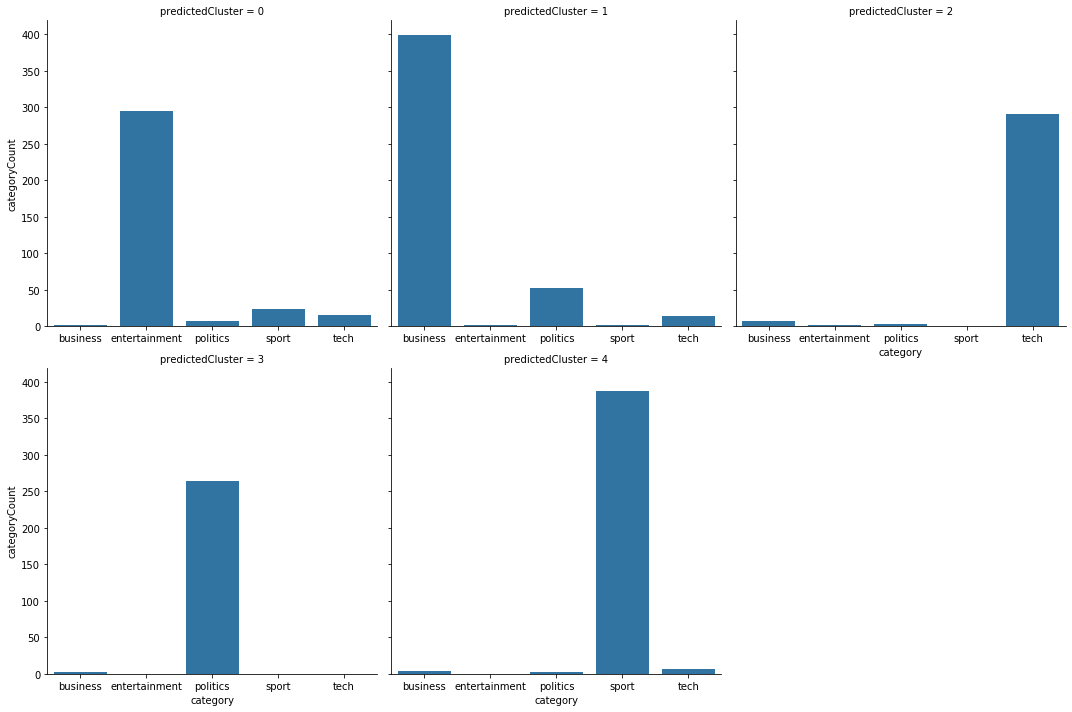

In [ ]:
g = sns.FacetGrid(distCategoriesInCluster5Clusters , col = 'predictedCluster' , sharex = False, col_wrap=3, height= 5, aspect=1)
g.map(sns.barplot, 'category', 'categoryCount', order=categoryOrder)

#### 3. Did the clustering do a good job of finding the categories?

Answer: It looks like all the clusters did really good at separating the articles of a particular category although cluster 0 and 1 added few documents from category other than the major category in that cluster

#### 4. Try this again with 6 clusters.

In [ ]:
kmeans6Clusters = KMeans(n_clusters=6, random_state=0).fit(articlesTrain_TFIDFV_tm)
predictedOutput6Clusters = kmeans6Clusters.predict(articlesTrain_TFIDFV_tm)

articlesTrain6Clusters = articlesTrain
articlesTrain6Clusters['predictedCluster'] = predictedOutput6Clusters

In [ ]:
distCategoriesInCluster6Clusters = articlesTrain6Clusters.groupby(['predictedCluster', 'category'])['category'].count().reset_index(name='categoryCount')
distCategoriesInCluster6Clusters

,predictedCluster,category,categoryCount
0,0,business,1
1,0,entertainment,278
2,0,sport,14
3,0,tech,9
4,1,business,142
5,1,entertainment,1
6,2,business,6
7,2,politics,3
8,2,tech,290
9,3,business,2


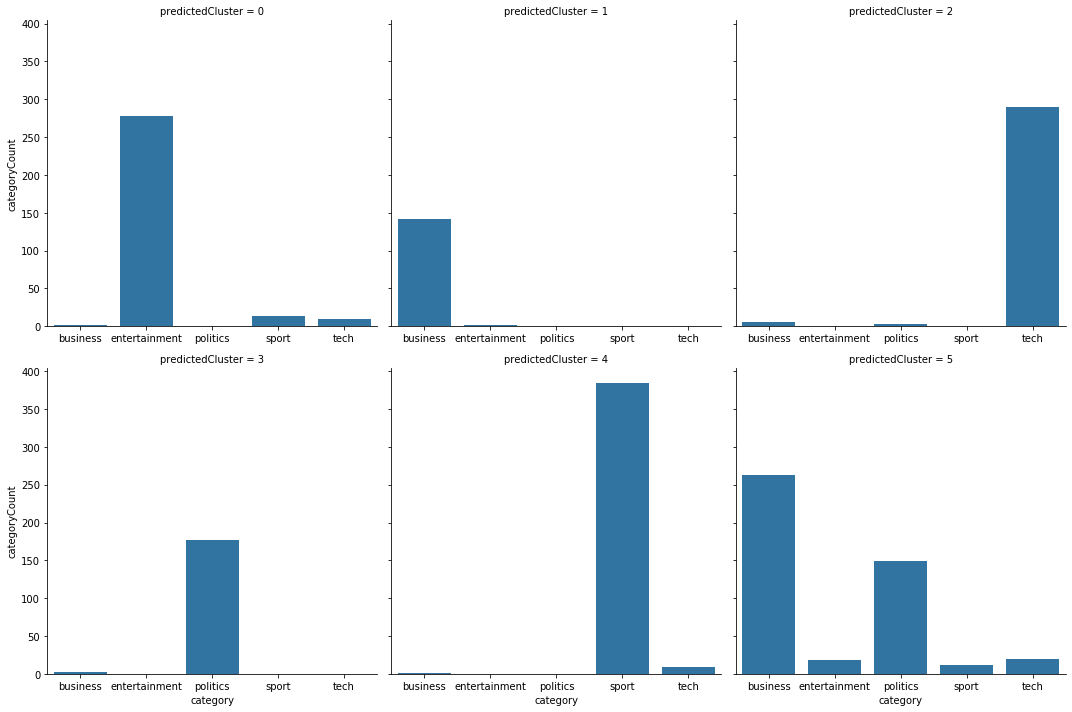

In [ ]:
g = sns.FacetGrid(distCategoriesInCluster6Clusters , col = 'predictedCluster' , sharex = False, col_wrap=3, height= 5, aspect=1)
g.map(sns.barplot, 'category', 'categoryCount', order=categoryOrder)

#### Do you think it did a better or worse job? Why do you think that is?

Answer: We think it did a worse job. Since we are trying to use 6 clusters where there are 5 categories, it is obvious that the documents of same categories will be splitted into more clusters than they should be.

#### 5. For each cluster in the one you think did a better job, find the words that are most important for that cluster. The KMeans object, after it has been fit, has a cluster_centers_ field containing a matrix. There is a row for each cluster, and the columns are features (in our case, words); it says where in word-space the middle of that cluster is. What words have the largest values for each cluster? Remember you can get the words with the vectorizer’s get_feature_names() method. You can get a row of the matrix with matrix[row, :], and use that with the feature names to make a series like we did in Class 11B. Do these words make sense in light of the documents in that cluster?

Let's go with 5 clusters:

find the words that are most important for clusters.

Cluster centers:

In [ ]:
cluster_centers = kmeans5Clusters.cluster_centers_
cluster_centers

array([[0.00022005, 0.00949299, 0.        , ..., 0.00033411, 0.        ,
        0.00068455],
       [0.        , 0.01334244, 0.0002283 , ..., 0.        , 0.        ,
        0.        ],
       [0.00017448, 0.01051769, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0002132 , 0.01194734, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00024412, 0.00234577, 0.        , ..., 0.        , 0.00010237,
        0.        ]])

Let's get the important words

In [ ]:
df = pd.DataFrame(data=cluster_centers, columns=txtcountTFIDFV.get_feature_names())
df

,00,000,000bn,000m,000s,000th,001,001and,001st,004,...,zonealarm,zones,zoom,zooms,zooropa,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0.000220,0.009493,0.000000,0.000000,0.000000,0.000808,0.000000,0.000000,0.000325,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000176,0.000000,0.000291,0.000334,0.000000,0.000685
1,0.000000,0.013342,0.000228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000155,...,0.000000,0.000515,0.000000,0.000000,0.000000,0.000000,0.000291,0.000000,0.000000,0.000000
2,0.000174,0.010518,0.000000,0.000000,0.000163,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000128,0.000446,0.000552,0.000379,0.000000,0.000000,0.000167,0.000000,0.000000,0.000000
3,0.000213,0.011947,0.000000,0.000000,0.000000,0.000000,0.000496,0.000248,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000244,0.002346,0.000000,0.005254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0.000809,0.000000,0.000102,0.000000


In [ ]:
df.transpose().idxmax()

0      film
1      said
2    mobile
3        mr
4      game
dtype: object

#### Do these words make sense in light of the documents in that cluster?

Answer: Cluster 0 mostly represents the category "entertainment". The word "film" makes sense in terms of this category. Similarly, the words "mobile", and "mr" and "game" makes sense for the clusters 2(tech), 3(politics), and 4(sport) respectively. However, the word "said" does not make much sense for the cluster 1

## Extra Credit: Dimensionality Reduction

The TruncatedSVD class in scikit-learn will transform your TF-IDF vectors into a lower-dimensional space, which simplifies storage and can improve the performance of certain algorithms. Fit a 8-dimensional truncated SVD to your model, and display a Seaborn pairplot of the 8 dimensions, with points colored by their document class. What do you observe?

In [ ]:
svd = TruncatedSVD(8)
u_vecs = svd.fit_transform(articlesTrain_TFIDFV_tm)
u_vecs

array([[ 0.15208207, -0.07268288, -0.10910103, ..., -0.00131946,
        -0.02623745, -0.00094775],
       [ 0.18599429, -0.00607259, -0.09866778, ..., -0.07435981,
        -0.0345385 , -0.06338513],
       [ 0.11614901,  0.00427908, -0.08433432, ...,  0.483489  ,
         0.25032419,  0.01142048],
       ...,
       [ 0.17990638, -0.01823747, -0.06649683, ...,  0.08841087,
        -0.13285522, -0.06856136],
       [ 0.11503856,  0.00907825, -0.05173344, ...,  0.02788488,
        -0.08179762, -0.08767176],
       [ 0.25291371, -0.14753665,  0.05561069, ..., -0.01737961,
         0.05123932,  0.0473388 ]])

In [ ]:
u_vecsDF = pd.DataFrame(u_vecs)
u_vecsDF['category'] = articlesTrain['category']
u_vecsDF

,0,1,2,3,4,5,6,7,category
0,0.152082,-0.072683,-0.109101,0.052165,0.050080,-0.001319,-0.026237,-0.000948,business
1,0.185994,-0.006073,-0.098668,0.168372,0.104413,-0.074360,-0.034539,-0.063385,business
2,0.116149,0.004279,-0.084334,0.123728,0.066920,0.483489,0.250324,0.011420,business
3,0.134618,-0.033411,-0.078891,0.098808,0.051278,-0.038721,-0.012797,0.017008,business
4,0.063881,-0.019062,-0.029105,0.035917,0.010659,0.020861,-0.004923,-0.006293,business
5,0.128814,-0.023487,-0.108398,0.145101,0.064611,-0.119030,0.001407,-0.011375,business
6,0.194622,0.003847,-0.144314,0.180549,0.095823,-0.139321,-0.027466,-0.025808,business
7,0.179980,0.008768,-0.069890,0.147092,0.057425,-0.051796,-0.011016,-0.033942,business
8,0.087932,-0.023200,-0.049595,0.034205,0.023994,-0.001045,-0.008754,0.003731,business
9,0.094003,0.022686,-0.048423,0.036710,0.018502,0.077542,-0.040672,-0.015225,business


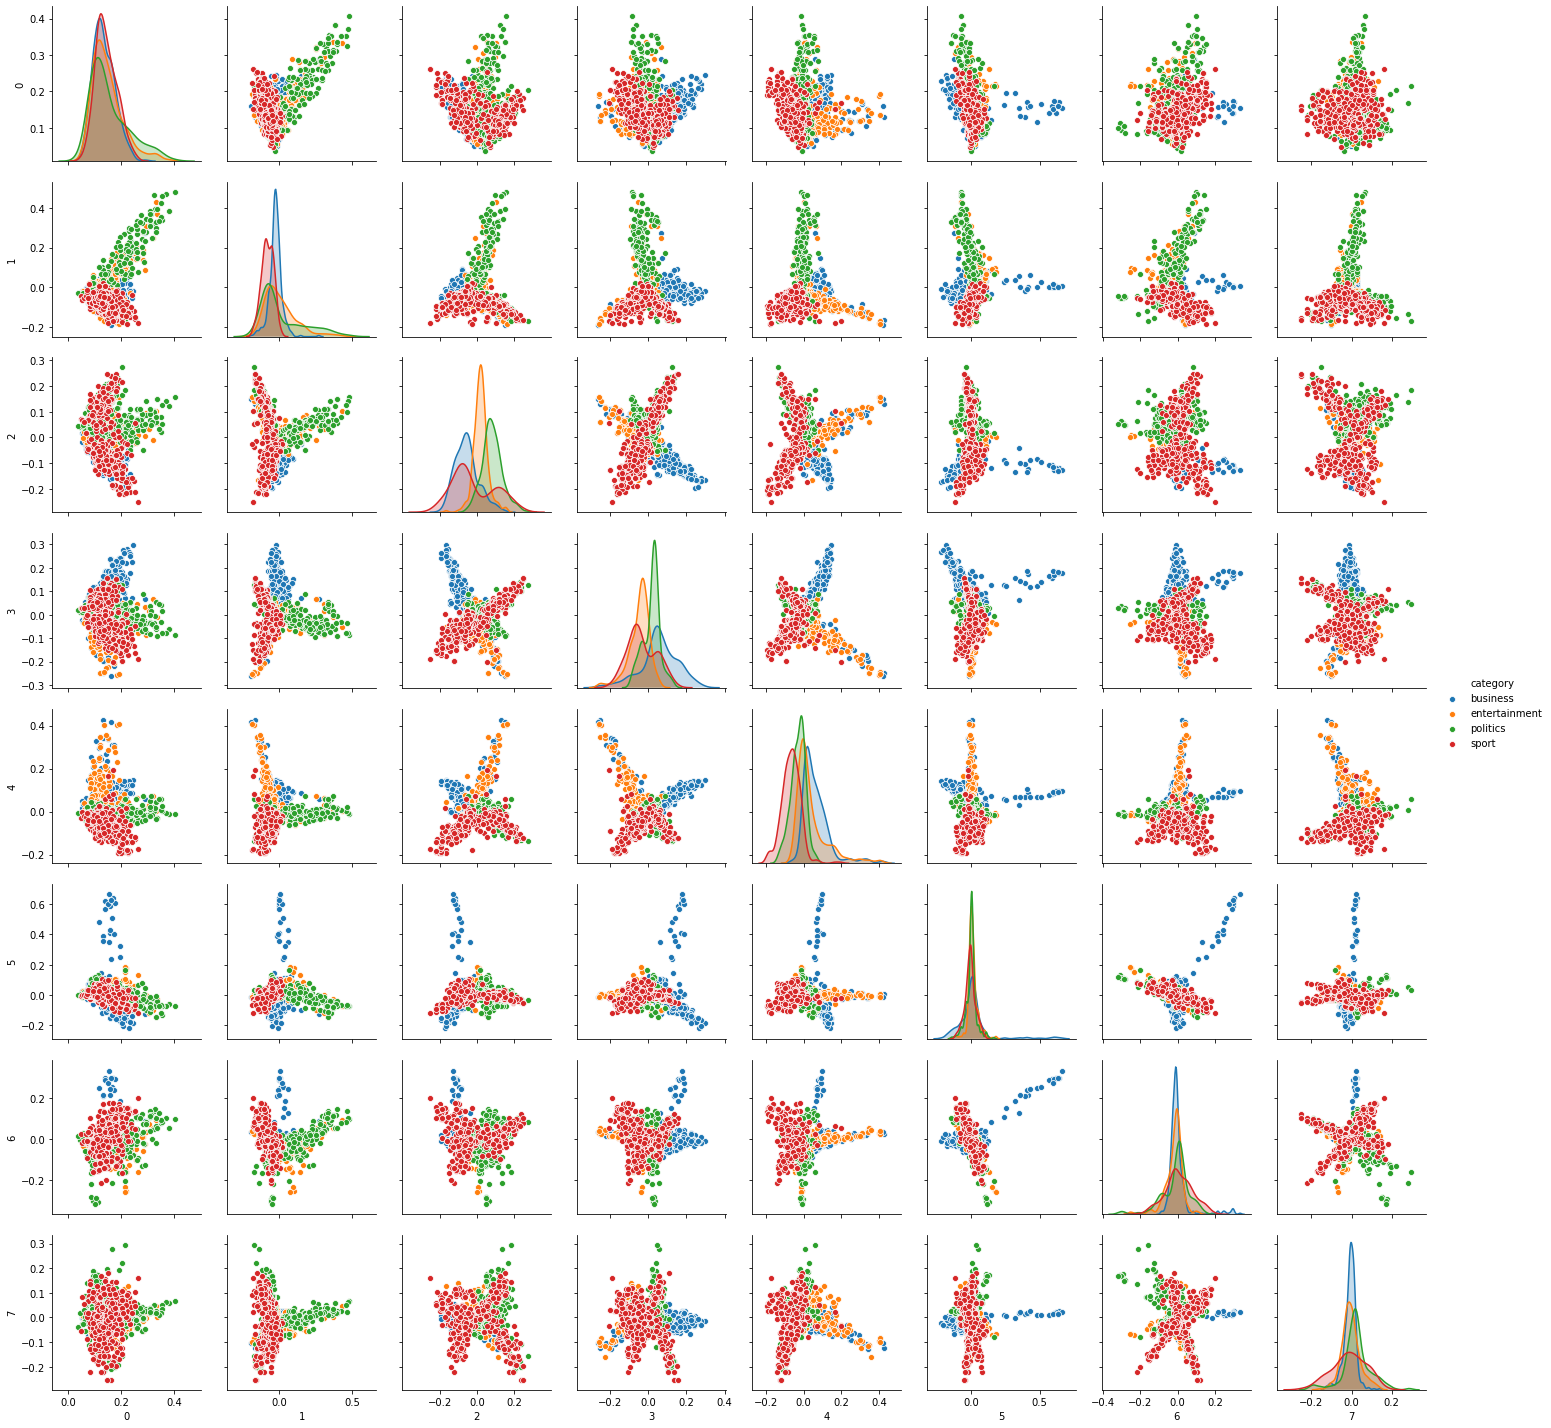

In [ ]:
g = sns.pairplot(u_vecsDF, hue="category")

#### What do you observe?

Answer: We can observe that the dimensions are following some patters in dividing the data in most cases. For example, most dimensions show good pattern with other dimensions. But for the first cluster, the patterns are not captured well with the other dimentions.

#### Modify your k-NN classifier setup to classify on the results of truncated SVD instead of raw TF-IDF vectors. Does it make its training performance better or worse?

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(u_vecs, articlesTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

training accuracy of this classifier:

In [ ]:
trainAccuracySvdKnn = (articlesTrain['category'] == neigh.predict(u_vecs)).mean()
trainAccuracySvdKnn

0.9685393258426966

##### Does it make its training performance better or worse?

Answer: It seems that it improves the accuracy only a bit.

#### Hold out a ‘dev’ set from your training data, and try 10 different dimension counts from 10 to 100, training k-NN on the output of each and using it to classify the dev data. Plot dev data accuracy vs. the dimensions. What feature count performs the best? Do any of them outperform plain k-NN?

For our example, We decided to take 60% of train data as dev data

In [ ]:
articlesDev = articlesTrain.sample(frac=0.60)
articlesDev.head()

,category,file,text,predictedCluster
649,entertainment,140.txt,Rock band U2 break ticket record\n\nU2 have sm...,0
580,entertainment,071.txt,UK debut for Kevin Spacey movie\n\nHollywood s...,0
1941,tech,118.txt,Progress on new internet domains\n\nBy early 2...,2
1193,politics,298.txt,'Debate needed' on donations cap\n\nA cap on d...,3
694,entertainment,185.txt,Oscar host Rock to keep it clean\n\nOscar host...,0


In [ ]:
dimensions = 10
accVsDimensions = pd.DataFrame(columns = ['accuracy', 'dimension'])
txtcountTFIDFV = TfidfVectorizer(stop_words='english')
articlesDev_TFIDFV_tm = txtcountTFIDFV.fit_transform(articlesDev['text'])

while dimensions <= 100:
    svd = TruncatedSVD(dimensions)
    u_vecs = svd.fit_transform(articlesDev_TFIDFV_tm)
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(u_vecs, articlesDev['category'])
    
    accuracy = (articlesDev['category'] == neigh.predict(u_vecs)).mean()
    
    
    data = [(accuracy, dimensions)]
    temp = pd.DataFrame(data, columns = ['accuracy', 'dimension'])
    accVsDimensions = pd.concat([accVsDimensions, temp])
    dimensions = dimensions + 10


In [ ]:
accVsDimensions

,accuracy,dimension
0,0.971910,10
0,0.975655,20
0,0.971910,30
0,0.958801,40
0,0.961610,50
0,0.957865,60
0,0.960674,70
0,0.959738,80
0,0.951311,90
0,0.960674,100


#### What feature count performs the best? Do any of them outperform plain k-NN?

In [ ]:
def getDimensionForMaxAcc(df):
    acc = df.loc[0][1]
    return acc

In [ ]:
topDimension = getDimensionForMaxAcc(accVsDimensions[accVsDimensions['accuracy'] == accVsDimensions['accuracy'].max()])
topDimension

20

Answer: Looks like dimension count 10, 20, 30 has out performed the plain k-NN.

#### Show the accuracy of Naive Bayes, k-NN, and SVD+k-NN on the test data, using the dimension count that performed the best on the dev data.

accuracy of Naive Bayes on test data is already calculated before:

In [ ]:
testAccuracyBayes

0.9730337078651685

accuracy of k-NN on test data is already calculated before:

In [ ]:
testAccuracyKNN

0.9258426966292135

For SVD+k-NN, 20 dimensions performed the best. Showing accuracy

In [ ]:
acc = accVsDimensions[accVsDimensions['dimension'] == 20]
acc['accuracy']

0    0.975655
Name: accuracy, dtype: float64